# Model 1. Understanding the accuracy of current endonasal image guidance system.

The current state of the art uses a tracked pointer, registered to a pre-operative MR scan. This notebook explores what the expected level of accuracy might be.






In [1]:
import numpy as np
import random
from matplotlib import pyplot as plt
import sksurgerycore.algorithms.procrustes as pro
import sksurgerycore.transforms.matrix as mu


## Utility functions

Here follows some useful utility functions. Scroll down to see the start of the analysis.

In [2]:
def create_transform(array_of_parameters):
    """
    Returns a homogeneous rigid transformation as 4x4 np.ndarray.
    
    :param array_of_parameters: list of [tx, ty, tz, rx, ry, rz] where rotations are in degrees.
    """
    rotation = mu.construct_rotm_from_euler(array_of_parameters[3],
                                            array_of_parameters[4],
                                            array_of_parameters[5],
                                            sequence='xyz',
                                            is_in_radians=False)
    translation = np.zeros((3,1))
    translation[0][0] = array_of_parameters[0]
    translation[1][0] = array_of_parameters[1]
    translation[2][0] = array_of_parameters[2]
    
    transform = mu.construct_rigid_transformation(rotation, translation)
    return transform
    
def multiply_points_by_matrix(matrix_4x4, matrix_of_points, do_transpose):
    """
    Multiplies all points by the same matrix.
    
    :param matrix_4x4: Numpy ndarray, 4x4, containing homogenous, rigid transformation
    :param matrix_of_points: Numpy ndarray, 4xN, containing N points as 4D homogeneous column vectors.
    :param do_transpose: if true, we also transpose
    """
    input_matrix = matrix_of_points
    
    if do_transpose:
        input_matrix = np.transpose(matrix_of_points)
        
    result = np.matmul(matrix_4x4, input_matrix)
    
    if do_transpose:
        result = np.transpose(result)
        
    return result

def multiply_point_by_matrix(transform, point_as_array):
    in_point = np.ones((4, 1))
    in_point[0][0] = point_as_array[0]
    in_point[1][0] = point_as_array[1]
    in_point[2][0] = point_as_array[2]
    out_point = np.matmul(transform, in_point)
    return out_point
    
def pointer_to_mri(Cam_T_PntRef, Cam_T_PatRef, PatRef_T_MRI, point_in_pointer_coords=[0, 0, 0]):
    """
    Converts a point in pointer space to MRI space.
    """
    transform = np.linalg.inv(PatRef_T_MRI) @ np.linalg.inv(Cam_T_PatRef) @ Cam_T_PntRef
    out_point = multiply_point_by_matrix(transform, point_in_pointer_coords)
    return out_point

def add_noise_to_points(points_in, sigma):
    points_out = np.zeros((points_in.shape))
    for r in range(points_in.shape[0]):
        for c in range(points_in.shape[1]):
            points_out[r][c] = points_in[r][c] + random.normalvariate(0, sigma)
    return points_out


## System layout

The following diagram shows the layout of the navigation system.

![img](./images/pointer_setup.png)

In the above image, we can see the general setup involved in the surgery when using a pointer. The goal is to be able to display the pointer in image coordinates as we can see in the image below:

![pointer on MRI](./images/MRI_pointer.png)

The goal is therefore turning the pointer's coordinates to MRI coordinates.

X<sub>MRI</sub> = T X<sub>PntEnd</sub>

where T are the transformations involved in turning from the pointer's point to the MRI coordinates. These transformations are the following:

T = <sup>MRI</sup>T<sub>PatRef</sub> * 
    <sup>PatRef</sup>T<sub>Cam</sub>  * 
    <sup>Cam</sup>T<sub>PntRef</sub> * 
    <sup>PntRef</sup>T<sub>endP</sub>
    
In the following sections we will go step by step on how to go from each of these transforms

Here is an image with all the transforms:

![pointer setup with transforms](./images/pointer_setup_transforms.png)

## Assumptions / setup

1. Cancer, patient reference, pointer reference are all aligned in z direction (have same z coordinate) and are facing the camera straight on so that the distance is D

2. Patient reference is at a set distance Yc from the cancer but aligned in the X direction

3. pointer is touching the cancer, so the pointer and cancer have the same coordinates

4. Length of pointer is known

5. Angle of pointer is known

![pointer assumptions from sagittal view](./images/pointer_setup_assumptions_sagittal.png)
![pointer assumptions from transverse view](./images/pointer_setup_assumptions_transverse.png)

## Configurable parameters

In [3]:
# ALL MEASUREMENTS IN MM

# P - length from tip of pointer to reference of pointer
pointer_length = 100

# D - z distance from camera to plane where everything is located
distance_from_cam = 1000 # since the camera and patient reference are aligned in the x and y directions, only distance is in z

# 0 - angle of pointer
pointer_angle = 45

# Yc - distances from cancer to patient reference
cancer_patref_y = 50  

## Creating the reference data for the pointer, in pointer coordinates.

Here is an image of the pointer with its reference:

![pointer image](./images/pointer_image.png)
![pointer image](./images/pointer_geometry.png)

In our case, let us assume we already know what the length of the pointer is.

In [4]:
print(f'pointer length is: {pointer_length}mm' )

pointer length is: 100mm


[[  0.   0.   0.   1.]
 [  0.   0.  50.   1.]
 [  0.  25. 100.   1.]
 [  0. -25. 135.   1.]]


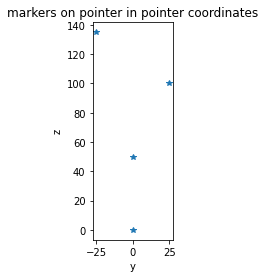

In [5]:
# Creating pointer reference (from datasheet). Using homogenous (4 numbers, x,y,z,1) as row vectors.
pnt_ref =  np.zeros((4, 4))

# marker b 
pnt_ref[1][2] = 50 # z

# marker c
pnt_ref[2][1] = 25  # y
pnt_ref[2][2] = 100 # z

# marker d
pnt_ref[3][1] = -25 # y
pnt_ref[3][2] = 135 # z

# adding 1 to 3rd dimension to turn to homogeneous coordinates
pnt_ref[0][3] = 1
pnt_ref[1][3] = 1
pnt_ref[2][3] = 1
pnt_ref[3][3] = 1
print(pnt_ref)

# Plotting original points, to check it looks ok.
plt.figure()
plt.plot(pnt_ref[:,1],pnt_ref[:,2], marker='*',linestyle = 'None',)
plt.title('markers on pointer in pointer coordinates')
plt.xlabel('y')
plt.ylabel('z')
plt.gca().set_aspect('equal', adjustable='box')

plt.show()


In [6]:
def get_Ref_T_End(pointer_length, dimension):
    if dimension == 'z':
        Ref_T_End = create_transform([0, 0, pointer_length, 0, 0, 0]) # create transform of all points depending on pointer's length
    elif dimension == 'x':
        Ref_T_End = create_transform([pointer_length, 0, 0, 0, 0, 0])
    return Ref_T_End


converting reference points to coordinate system where the origin is at the end of the pointer

Original pointer, as per datasheet:
[[  0.   0.   0.   1.]
 [  0.   0.  50.   1.]
 [  0.  25. 100.   1.]
 [  0. -25. 135.   1.]]
offset_pointer_transform=
[[  1.   0.   0.   0.]
 [  0.   1.   0.   0.]
 [  0.   0.   1. 100.]
 [  0.   0.   0.   1.]]
pnt_ref_transformed=
[[  0.   0. 100.   1.]
 [  0.   0. 150.   1.]
 [  0.  25. 200.   1.]
 [  0. -25. 235.   1.]]
pnt_ref_with_tip=
[[  0.   0. 100.   1.]
 [  0.   0. 150.   1.]
 [  0.  25. 200.   1.]
 [  0. -25. 235.   1.]
 [  0.   0.   0.   1.]]


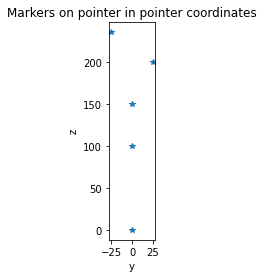

In [7]:
# Here we offset the points by the length of the pointer.
offset_pointer_transform = get_Ref_T_End(pointer_length, 'z') # create transform of all points depending on pointer's length
pnt_ref_transformed = multiply_points_by_matrix(offset_pointer_transform, pnt_ref, do_transpose=True) # transform all pointer points by this reference
pnt_ref_with_tip = np.concatenate((pnt_ref_transformed, [[0, 0, 0, 1]]), axis=0) # adding tip to points

# displaying results
print("Original pointer, as per datasheet:\n" + str(pnt_ref))
print("offset_pointer_transform=\n" + str(offset_pointer_transform))
print("pnt_ref_transformed=\n" + str(pnt_ref_transformed))
print("pnt_ref_with_tip=\n" + str(pnt_ref_with_tip))

plt.figure()
plt.plot(pnt_ref_with_tip[:,1],pnt_ref_with_tip[:,2], marker='*',linestyle = 'None',)
plt.title('Markers on pointer in pointer coordinates')
plt.xlabel('y')
plt.ylabel('z')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

## Creating the reference data for the pointer in camera coordinates

Pointer in camera/tracker space:
[[  0.   0.   0.   1.]
 [ 50.   0.   0.   1.]
 [100.  25.   0.   1.]
 [135. -25.   0.   1.]]
offset_pointer_transform_cam=
[[  1.   0.   0. 100.]
 [  0.   1.   0.   0.]
 [  0.   0.   1.   0.]
 [  0.   0.   0.   1.]]
pnt_ref_in_camera_space_transformed=
[[100.   0.   0.   1.]
 [150.   0.   0.   1.]
 [200.  25.   0.   1.]
 [235. -25.   0.   1.]]
pnt_ref_in_camera_space_with_tip=
[[100.   0.   0.   1.]
 [150.   0.   0.   1.]
 [200.  25.   0.   1.]
 [235. -25.   0.   1.]
 [  0.   0.   0.   1.]]
pnt_ref_in_camera_space_at_patient=
[[  70.71067812   70.71067812 1000.            1.        ]
 [ 106.06601718  106.06601718 1000.            1.        ]
 [ 123.74368671  159.09902577 1000.            1.        ]
 [ 183.84776311  148.49242405 1000.            1.        ]
 [   0.            0.         1000.            1.        ]]


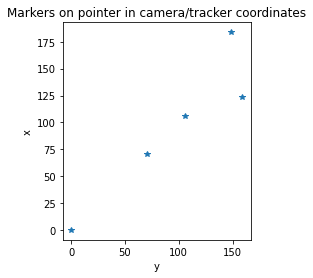

In [8]:
pnt_ref_in_camera_space =  np.zeros((4, 4))

# marker b
pnt_ref_in_camera_space[1][0] = 50 # x
# marker c
pnt_ref_in_camera_space[2][0] = 100 # x
pnt_ref_in_camera_space[2][1] = 25 # should this be -y?------- to check
# marker d
pnt_ref_in_camera_space[3][0] = 135 # x
pnt_ref_in_camera_space[3][1] = -25 # should this be -y?----- to check

# adding 1 to third dimension to make homogeneous coords
pnt_ref_in_camera_space[0][3] = 1
pnt_ref_in_camera_space[1][3] = 1
pnt_ref_in_camera_space[2][3] = 1
pnt_ref_in_camera_space[3][3] = 1

# once again creating offset to all the points to move origin to the pointer's tip
offset_pointer_transform_cam = get_Ref_T_End(pointer_length, 'x')
pnt_ref_in_camera_space_transformed = multiply_points_by_matrix(offset_pointer_transform_cam, pnt_ref_in_camera_space, do_transpose=True)
pnt_ref_in_camera_space_with_tip = np.concatenate((pnt_ref_in_camera_space_transformed, [[0, 0, 0, 1]]), axis=0)

print("Pointer in camera/tracker space:\n" + str(pnt_ref_in_camera_space))
print("offset_pointer_transform_cam=\n" + str(offset_pointer_transform_cam))
print("pnt_ref_in_camera_space_transformed=\n" + str(pnt_ref_in_camera_space_transformed))
print("pnt_ref_in_camera_space_with_tip=\n" + str(pnt_ref_in_camera_space_with_tip))

# Now we want to rotate around z (according to diagram above), then translate to a distance from camera.
rotate_about_z = create_transform([0, 0, 0, 0, 0, pointer_angle]) 
translate_away_from_camera = create_transform([0, 0, distance_from_cam, 0, 0, 0])
pnt_ref_in_camera_space_at_patient = multiply_points_by_matrix(translate_away_from_camera @ rotate_about_z, pnt_ref_in_camera_space_with_tip, do_transpose=True)
print("pnt_ref_in_camera_space_at_patient=\n" + str(pnt_ref_in_camera_space_at_patient))

# Plotting result
plt.figure()
plt.plot(pnt_ref_in_camera_space_at_patient[:,1],pnt_ref_in_camera_space_at_patient[:,0], marker='*',linestyle = 'None',)
plt.title('Markers on pointer in camera/tracker coordinates')
plt.xlabel('y')
plt.ylabel('x')
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

## Computing the Tracking transformation, Cam_T_PntRef.

For sanity checking, we should now be able to register the PntRef model (moving) to Cam (fixed) transform.

In [9]:
Cam_T_PntRef_r, Cam_T_PntRef_t, Cam_T_PntRef_FRE = pro.orthogonal_procrustes(pnt_ref_in_camera_space_at_patient[:,0:3], pnt_ref_with_tip[:,0:3])
print("Cam_T_PntRef_r=\n" + str(Cam_T_PntRef_r))
print("Cam_T_PntRef_t=\n" + str(Cam_T_PntRef_t))
print("Cam_T_PntRef_FRE=\n" + str(Cam_T_PntRef_FRE))

# Also, construct a 4x4 tracking transformation. It should look like a rotation and a translation.
Cam_T_PntRef = mu.construct_rigid_transformation(Cam_T_PntRef_r, Cam_T_PntRef_t)
print("Cam_T_PntRef=\n" + str(Cam_T_PntRef))


Cam_T_PntRef_r=
[[ 1.38483821e-15 -7.07106781e-01  7.07106781e-01]
 [-1.62248986e-15  7.07106781e-01  7.07106781e-01]
 [-1.00000000e+00 -2.11636264e-15  0.00000000e+00]]
Cam_T_PntRef_t=
[[5.68434189e-14]
 [2.84217094e-14]
 [1.00000000e+03]]
Cam_T_PntRef_FRE=
3.759838749409412e-14
Cam_T_PntRef=
[[ 1.38483821e-15 -7.07106781e-01  7.07106781e-01  5.68434189e-14]
 [-1.62248986e-15  7.07106781e-01  7.07106781e-01  2.84217094e-14]
 [-1.00000000e+00 -2.11636264e-15  0.00000000e+00  1.00000000e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


## Creating reference data for the the Patient Reference

![real patient reference](./images/real_pat_ref.png)


![patient reference coordinates](./images/pointer_patref_marker.png)

In [10]:
# Defining reference coordibates in ref coords (from datasheet)
#A: x=0.00, y= 0.00, z=0.00 
#B: x=0.00, y= 28.59, z=41.02 
#C: x=0.00, y= 00.00, z=88.00 
#D: x=0.00, y=-44.32, z=40.45
    
# Encoding the reference marker points into a numpy matrix
pat_ref = np.zeros((4, 4))

# marker b
pat_ref[1][1] = 28.59 # y
pat_ref[1][2] = 41.02 # z

# marker c
pat_ref[2][2] = 88 # z

# marker d
pat_ref[3][1] = -44.32 # y
pat_ref[3][2] = 40.45 # z

# adding 1 to last row to make coordinates homogenous
pat_ref[0][3] = 1.0
pat_ref[1][3] = 1.0 
pat_ref[2][3] = 1.0
pat_ref[3][3] = 1.0


## Creating the reference data for the patient reference in camera space.

- we assume the patient reference centre is at the same level as the cancer and so the x coordinates are the same
- the distance in y direction between cancer and reference is known


![reminder of patient reference assumptions](./images/pat_ref_assumptions.png)

The patient reference model coordinates are in the YZ plane. In camera space, the X direction is vertical, the Z direction goes from the camera to the patient. So, in camera space, lets place these points in the ZY plane. So, all we have to do is swap the Y, Z coordinates, then translate to the patient, then translate along the negative Y axis to match the picture above. 


In [11]:
# Encoding the reference marker points into a numpy matrix, in camera space.
pat_ref_in_camera_space = np.zeros((4, 4))

#  TO ASK MATT-------> Which direction????
pat_ref_in_camera_space[1][1] = 41.02 # 
pat_ref_in_camera_space[1][2] = 28.59

pat_ref_in_camera_space[2][1] = 88 

pat_ref_in_camera_space[3][1] = 40.45
pat_ref_in_camera_space[3][2] = -44.32 

'''

# marker b
pat_ref[1][1] = 28.59 # y
pat_ref[1][2] = 41.02 # z

# marker c
pat_ref[2][2] = 88 # z

# marker d
pat_ref[3][1] = -44.32 # y
pat_ref[3][2] = 40.45 # z
'''
print(pat_ref)
print(pat_ref_in_camera_space)

# converting to homogenous coords
pat_ref_in_camera_space[0][3] = 1.0 
pat_ref_in_camera_space[1][3] = 1.0
pat_ref_in_camera_space[2][3] = 1.0
pat_ref_in_camera_space[3][3] = 1.0


# Now put it in the right place.
translate_along_negative_y = create_transform([0, -cancer_patref_y, 0, 0, 0, 0])
pat_ref_in_camera_space_at_patient = multiply_points_by_matrix(translate_along_negative_y @ translate_away_from_camera, pat_ref_in_camera_space, do_transpose=True)

print("Patient ref, in model coordinates=\n" + str(pat_ref))
print("Patient ref, in camera coordinates=\n" + str(pat_ref_in_camera_space_at_patient))



[[  0.     0.     0.     1.  ]
 [  0.    28.59  41.02   1.  ]
 [  0.     0.    88.     1.  ]
 [  0.   -44.32  40.45   1.  ]]
[[  0.     0.     0.     0.  ]
 [  0.    41.02  28.59   0.  ]
 [  0.    88.     0.     0.  ]
 [  0.    40.45 -44.32   0.  ]]
Patient ref, in model coordinates=
[[  0.     0.     0.     1.  ]
 [  0.    28.59  41.02   1.  ]
 [  0.     0.    88.     1.  ]
 [  0.   -44.32  40.45   1.  ]]
Patient ref, in camera coordinates=
[[ 0.00000e+00 -5.00000e+01  1.00000e+03  1.00000e+00]
 [ 0.00000e+00 -8.98000e+00  1.02859e+03  1.00000e+00]
 [ 0.00000e+00  3.80000e+01  1.00000e+03  1.00000e+00]
 [ 0.00000e+00 -9.55000e+00  9.55680e+02  1.00000e+00]]


## Computing the Tracking transformation Cam_T_PatRef

In [12]:

# As above, compute the tracking transformation.
Cam_T_PatRef_r, Cam_T_PatRef_t, Cam_T_PatRef_FRE = pro.orthogonal_procrustes(pat_ref_in_camera_space_at_patient[:,0:3], pat_ref[:,0:3])
print("Cam_T_PatRef_r=\n" + str(Cam_T_PatRef_r))
print("Cam_T_PatRef_t=\n" + str(Cam_T_PatRef_t))
print("Cam_T_PatRef_FRE=\n" + str(Cam_T_PatRef_FRE))

# Also, construct a 4x4 tracking transformation. It should look like a translation, with no rotation.
Cam_T_PatRef = mu.construct_rigid_transformation(Cam_T_PatRef_r, Cam_T_PatRef_t)
print("Cam_T_PatRef=\n" + str(Cam_T_PatRef))


Cam_T_PatRef_r=
[[-1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  3.46944695e-17  1.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00 -9.02056208e-17]]
Cam_T_PatRef_t=
[[   0.]
 [ -50.]
 [1000.]]
Cam_T_PatRef_FRE=
7.105427357601002e-15
Cam_T_PatRef=
[[-1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  3.46944695e-17  1.00000000e+00 -5.00000000e+01]
 [ 0.00000000e+00  1.00000000e+00 -9.02056208e-17  1.00000000e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


## CT to PatRef coordinates

In order to convert CT coordinates to patient reference coordinates, we typically would take the pointer and move it over the surface of the patient's head. The software would collect coordinates of the tip of the pointer, and transform them to the patient reference coordinate system. We then use an ICP algorithm to match the two surfaces of the points on the face. This results in PatRef_T_MRI as shown above.

For the purpose of this simulation, we can just place them at an offset to the patient reference, which has already been placed, somewhere near the patients head.

![MRI to camera coordinates](./images/3D_to_cam.png)

In [13]:
# Average head dimensions from: https://en.wikipedia.org/wiki/Human_head

x_t = 100 # head length (about 20cm)
y_t = 130 # menton to top of head (about 25cm)
z_t = 80 # head bredth (about 15cm)

PatRef_T_MRI = create_transform([-x_t, -y_t, -z_t, 0, 0, 0])
print("Cam_T_PntRef=\n" + str(PatRef_T_MRI))

Cam_T_PntRef=
[[   1.    0.    0. -100.]
 [   0.    1.    0. -130.]
 [   0.    0.    1.  -80.]
 [   0.    0.    0.    1.]]


# Summary of Reference data.

Give this setup:

![pointer setup with transforms](./images/pointer_setup_transforms.png)

we have now computed

In [14]:
print("Summary: pointer tip to pointer ref PntRef_T_EndP =\n" + str(offset_pointer_transform)) 
print("Summary: pointer ref to camera Cam_T_PntRef=\n" + str(Cam_T_PntRef)) 
print("Summary: patient ref to camera Cam_T_PatRef=\n" + str(Cam_T_PatRef))
print("Summary: mri to patient ref PatRef_T_MRI=\n" + str(PatRef_T_MRI))

Summary: pointer tip to pointer ref PntRef_T_EndP =
[[  1.   0.   0.   0.]
 [  0.   1.   0.   0.]
 [  0.   0.   1. 100.]
 [  0.   0.   0.   1.]]
Summary: pointer ref to camera Cam_T_PntRef=
[[ 1.38483821e-15 -7.07106781e-01  7.07106781e-01  5.68434189e-14]
 [-1.62248986e-15  7.07106781e-01  7.07106781e-01  2.84217094e-14]
 [-1.00000000e+00 -2.11636264e-15  0.00000000e+00  1.00000000e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Summary: patient ref to camera Cam_T_PatRef=
[[-1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  3.46944695e-17  1.00000000e+00 -5.00000000e+01]
 [ 0.00000000e+00  1.00000000e+00 -9.02056208e-17  1.00000000e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Summary: mri to patient ref PatRef_T_MRI=
[[   1.    0.    0. -100.]
 [   0.    1.    0. -130.]
 [   0.    0.    1.  -80.]
 [   0.    0.    0.    1.]]


and dont forget that we constructed the pointer, so that the origin is the tip, and we computed Cam_T_PntRef based on this. So, in the above diagram, PntRef_T_EndP is effectively the identity transformation.

In addition, we can just place the tumour at the location given by the pointer tip:


In [69]:
origin = [0, 0, 0]

# Tumor in camera space
#tumour_in_camera_space = multiply_point_by_matrix(Cam_T_PntRef, origin)
tumour_in_camera_space = np.array([ [0],[0],[distance_from_cam],[1] ])
print("Tumour location in camera space=\n" + str(tumour_in_camera_space))

# Tumor in MRI space
tumour_in_mri_space = pointer_to_mri(Cam_T_PntRef, Cam_T_PatRef, PatRef_T_MRI, origin)
print("Tumour location in MRI space=\n" + str(tumour_in_mri_space))

# Transforming tumor in camera space to MRI space to check it is the same   
transform = np.linalg.inv(PatRef_T_MRI) @ np.linalg.inv(Cam_T_PatRef) 
tumour_MRI_from_Cam = multiply_point_by_matrix(transform, tumour_in_camera_space)
print('Tumour location in MRI space after transforming camera space one')
print(tumour_MRI_from_Cam)

Tumour location in camera space=
[[   0]
 [   0]
 [1000]
 [   1]]
Tumour location in MRI space=
[[100.]
 [130.]
 [130.]
 [  1.]]
Tumour location in MRI space after transforming camera space one
[[100.]
 [130.]
 [130.]
 [  1.]]


And we have the following reference data from above:

In [16]:
print("Pointer model=\n" + str(pnt_ref_with_tip))
print("Pointer model in camera space=\n" + str(pnt_ref_in_camera_space_at_patient))
print("Patient ref model=\n" + str(pat_ref))
print("Patient ref model in camera space=\n" + str(pat_ref_in_camera_space_at_patient))


Pointer model=
[[  0.   0. 100.   1.]
 [  0.   0. 150.   1.]
 [  0.  25. 200.   1.]
 [  0. -25. 235.   1.]
 [  0.   0.   0.   1.]]
Pointer model in camera space=
[[  70.71067812   70.71067812 1000.            1.        ]
 [ 106.06601718  106.06601718 1000.            1.        ]
 [ 123.74368671  159.09902577 1000.            1.        ]
 [ 183.84776311  148.49242405 1000.            1.        ]
 [   0.            0.         1000.            1.        ]]
Patient ref model=
[[  0.     0.     0.     1.  ]
 [  0.    28.59  41.02   1.  ]
 [  0.     0.    88.     1.  ]
 [  0.   -44.32  40.45   1.  ]]
Patient ref model in camera space=
[[ 0.00000e+00 -5.00000e+01  1.00000e+03  1.00000e+00]
 [ 0.00000e+00 -8.98000e+00  1.02859e+03  1.00000e+00]
 [ 0.00000e+00  3.80000e+01  1.00000e+03  1.00000e+00]
 [ 0.00000e+00 -9.55000e+00  9.55680e+02  1.00000e+00]]


which are the 4 sets of points that we computed tracking transformations from, using orthogonal procrustes.

# Summary of steps

#### PntRef_T_PntEnd

pointer reference

In [48]:
pnt_ref

array([[  0.,   0.,   0.,   1.],
       [  0.,   0.,  50.,   1.],
       [  0.,  25., 100.,   1.],
       [  0., -25., 135.,   1.]])

PntRef_T_PntEnd

We transform the pointer reference from reference coordinates to pointer's end coordinate system, where the origin is at the pointer's tip


In [49]:
PntRef_T_PntEnd = get_Ref_T_End(pointer_length, 'z')
# pointer reference in endoscopic coordinates
pnt_ref_transformed = multiply_points_by_matrix(PntRef_T_PntEnd, pnt_ref, do_transpose=True) # transform all pointer points by this transform
print('pointer reference after being translated by pointer length (PntRef_T_PntEnd)')
print(pnt_ref_transformed)

pointer reference after being translated by pointer length (PntRef_T_PntEnd)
[[  0.   0.  10.   1.]
 [  0.   0.  60.   1.]
 [  0.  25. 110.   1.]
 [  0. -25. 145.   1.]]


#### Cam_T_PntRef

We now create the reference but in camera coordinates

Original reference (as the scale is the same)

In [50]:
pnt_ref_in_camera_space

array([[  0.,   0.,   0.,   1.],
       [ 50.,   0.,   0.,   1.],
       [100.,  25.,   0.,   1.],
       [135., -25.,   0.,   1.]])

We translate it so that the origin is at the pointer's tip

In [51]:
offset_pointer_transform_cam = get_Ref_T_End(pointer_length, 'x')
pnt_ref_in_camera_space_offset = multiply_points_by_matrix(offset_pointer_transform_cam, pnt_ref_in_camera_space, do_transpose=True)
print('pointer reference after being translated by pointer length (camera)')
print(pnt_ref_in_camera_space_offset)


pointer reference after being translated by pointer length (camera)
[[ 10.   0.   0.   1.]
 [ 60.   0.   0.   1.]
 [110.  25.   0.   1.]
 [145. -25.   0.   1.]]


We then want to rotate it to the angle specified and translate it away from the camera at the distance the patient is from the camera


In [52]:
# Now we want to rotate around z (according to diagram above), then translate to a distance from camera.
rotate_about_z = create_transform([0, 0, 0, 0, 0, pointer_angle]) 
translate_away_from_camera = create_transform([0, 0, distance_from_cam, 0, 0, 0])

# composing the 2 transformations
rotate_translate = translate_away_from_camera @ rotate_about_z 

# transforming reference coordinates by these transformations
pnt_ref_in_camera_space_transformed = multiply_points_by_matrix(rotate_translate, pnt_ref_in_camera_space_offset, do_transpose=True)

print('pnt_ref_in_camera_space_transformed is pointer reference in camera coordinates (after being put in position)')
print(pnt_ref_in_camera_space_transformed)


pnt_ref_in_camera_space_transformed is pointer reference in camera coordinates (after being put in position)
[[   7.07106781    7.07106781 1000.            1.        ]
 [  42.42640687   42.42640687 1000.            1.        ]
 [  60.1040764    95.45941546 1000.            1.        ]
 [ 120.2081528    84.85281374 1000.            1.        ]]


Now we have the pointer's reference both in camera coordinates and in pointer coordinates so we can get the transformation Cam_T_PntRef by matching the two

In [53]:
print('pointer reference in reference coords: ')
print(pnt_ref_transformed[:,0:3])

print('pointer reference in camera coords: ')
print(pnt_ref_in_camera_space_transformed[:,0:3])


pointer reference in reference coords: 
[[  0.   0.  10.]
 [  0.   0.  60.]
 [  0.  25. 110.]
 [  0. -25. 145.]]
pointer reference in camera coords: 
[[   7.07106781    7.07106781 1000.        ]
 [  42.42640687   42.42640687 1000.        ]
 [  60.1040764    95.45941546 1000.        ]
 [ 120.2081528    84.85281374 1000.        ]]


In [54]:
Cam_T_PntRef_r, Cam_T_PntRef_t, _ = pro.orthogonal_procrustes(pnt_ref_in_camera_space_transformed[:,0:3], pnt_ref_transformed[:,0:3])

# Now we construct the 4x4 tracking transformation. 
Cam_T_PntRef = mu.construct_rigid_transformation(Cam_T_PntRef_r, Cam_T_PntRef_t)
print("Cam_T_PntRef=\n" + str(Cam_T_PntRef))

Cam_T_PntRef=
[[ 1.59218830e-16 -7.07106781e-01  7.07106781e-01  7.10542736e-15]
 [-1.92482452e-16  7.07106781e-01  7.07106781e-01  0.00000000e+00]
 [-1.00000000e+00 -2.77555756e-16  0.00000000e+00  1.00000000e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


#### PatRef_T_Cam

We have the original patient reference in patient reference coordinates

In [55]:
pat_ref

array([[  0.  ,   0.  ,   0.  ,   1.  ],
       [  0.  ,  28.59,  41.02,   1.  ],
       [  0.  ,   0.  ,  88.  ,   1.  ],
       [  0.  , -44.32,  40.45,   1.  ]])

Similarly to the pointer reference, we want to get it in camera coordinates so we can get the transform between the two


We start with the reference at the same scale but swapping the necessary axes

In [56]:
pat_ref_in_camera_space

array([[  0.  ,   0.  ,   0.  ,   1.  ],
       [  0.  ,  41.02,  28.59,   1.  ],
       [  0.  ,  88.  ,   0.  ,   1.  ],
       [  0.  ,  40.45, -44.32,   1.  ]])

And we then move the reference so that it is at the correct position- both away from the camera and relative to the patient

In [57]:
# translation to correct place relative to patient
translate_along_negative_y = create_transform([0, -cancer_patref_y, 0, 0, 0, 0])
# composing transformation of translation relative to patient and translation away from the camera (which was calculated previously)
positioning_pat_ref_transform = translate_along_negative_y @ translate_away_from_camera

# moving all patient reference points by the calculated translation
pat_ref_in_camera_space_at_patient = multiply_points_by_matrix(positioning_pat_ref_transform, pat_ref_in_camera_space, do_transpose=True)


So now we have the patient reference both in reference coordinates and in camera coordinates.

In [58]:
print("Patient ref, in model coordinates=\n" + str(pat_ref))
print("Patient ref, in camera coordinates=\n" + str(pat_ref_in_camera_space_at_patient))

Patient ref, in model coordinates=
[[  0.     0.     0.     1.  ]
 [  0.    28.59  41.02   1.  ]
 [  0.     0.    88.     1.  ]
 [  0.   -44.32  40.45   1.  ]]
Patient ref, in camera coordinates=
[[ 0.00000e+00 -5.00000e+01  1.00000e+03  1.00000e+00]
 [ 0.00000e+00 -8.98000e+00  1.02859e+03  1.00000e+00]
 [ 0.00000e+00  3.80000e+01  1.00000e+03  1.00000e+00]
 [ 0.00000e+00 -9.55000e+00  9.55680e+02  1.00000e+00]]


Therefore we can get the transformation between the two by matching the points

In [59]:
# First we compute the tracking transformation.
Cam_T_PatRef_r, Cam_T_PatRef_t, _ = pro.orthogonal_procrustes(pat_ref_in_camera_space_at_patient[:,0:3], pat_ref[:,0:3])

# And then construct the corresponding 4x4 tracking transformation. 
Cam_T_PatRef = mu.construct_rigid_transformation(Cam_T_PatRef_r, Cam_T_PatRef_t)
print("Cam_T_PatRef=\n" + str(Cam_T_PatRef))


Cam_T_PatRef=
[[-1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  3.46944695e-17  1.00000000e+00 -5.00000000e+01]
 [ 0.00000000e+00  1.00000000e+00 -9.02056208e-17  1.00000000e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


#### MRI_T_PatRef

Finally we have the transformation between the patient reference and the MRI

In [60]:
# Average head dimensions from: https://en.wikipedia.org/wiki/Human_head

x_t = 100 # head length (about 20cm)
y_t = 130 # menton to top of head (about 25cm)
z_t = 80 # head bredth (about 15cm)

PatRef_T_MRI = create_transform([-x_t, -y_t, -z_t, 0, 0, 0])
print("PatRef_T_MRI=\n" + str(PatRef_T_MRI))

PatRef_T_MRI=
[[   1.    0.    0. -100.]
 [   0.    1.    0. -130.]
 [   0.    0.    1.  -80.]
 [   0.    0.    0.    1.]]


#### Trying these transformations out

In [63]:
print('PntRef_T_PntEnd=\n', PntRef_T_PntEnd)
print('Cam_T_PntRef=\n', Cam_T_PntRef)
print('Cam_T_PatRef=\n', Cam_T_PatRef)
print('PatRef_T_MRI=\n', PatRef_T_MRI)


PntRef_T_PntEnd=
 [[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1. 10.]
 [ 0.  0.  0.  1.]]
Cam_T_PntRef=
 [[ 1.59218830e-16 -7.07106781e-01  7.07106781e-01  7.10542736e-15]
 [-1.92482452e-16  7.07106781e-01  7.07106781e-01  0.00000000e+00]
 [-1.00000000e+00 -2.77555756e-16  0.00000000e+00  1.00000000e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Cam_T_PatRef=
 [[-1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  3.46944695e-17  1.00000000e+00 -5.00000000e+01]
 [ 0.00000000e+00  1.00000000e+00 -9.02056208e-17  1.00000000e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
PatRef_T_MRI=
 [[   1.    0.    0. -100.]
 [   0.    1.    0. -130.]
 [   0.    0.    1.  -80.]
 [   0.    0.    0.    1.]]


# Simulation 1: Effect of tracking noise on pointer tip accuracy.

Here we add random noise to the location of the tracking markers (pointer and patient ref) and see how far tip position moves relative to the tumour.

### Pseudo code

* initialise some arrays to store accuracy data, so we can then compute mean/stddev.
* for sigma in 0.1 to 1, in steps of 0.1
*   for iteration in 1 to 10,000.
*     add zero mean Gaussian(sigma) noise to each tracking marker. 
*     recompute transforms.
*     recompute position of pointer tip
*     measure Euclidean distance in MRI space
* 
*   compute RMS error over each iteration
* produce graph of RMS (TRE) for each value of sigma


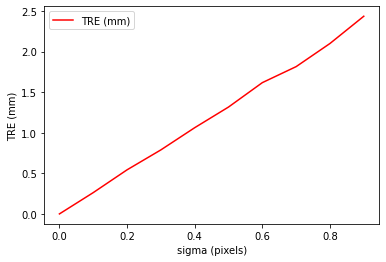

In [20]:
number_samples = 1000
x_values = []
y_values = []
for sigma_counter in range(0, 10, 1):
    sigma = float(sigma_counter) / float(10)
    rms = 0
    for i in range(number_samples):
        tmp_pointer = add_noise_to_points(pnt_ref_in_camera_space_at_patient[0:4,0:3], sigma) # Mustn't include pointer tip! 
        tmp_ref = add_noise_to_points(pat_ref_in_camera_space_at_patient[:,0:3], sigma)
        
        R, t, FRE = pro.orthogonal_procrustes(tmp_pointer, pnt_ref_with_tip[0:4, 0:3])
        tmp_pointer_to_cam = mu.construct_rigid_transformation(R, t)
        
        R, t, FRE = pro.orthogonal_procrustes(tmp_ref, pat_ref[0:4, 0:3])
        tmp_reference_to_cam = mu.construct_rigid_transformation(R, t)
        
        pointer_tip_in_mri_space = pointer_to_mri(tmp_pointer_to_cam, tmp_reference_to_cam, PatRef_T_MRI, origin)
        
        # euclid_dist is x^2+y^2+x^2
        euclid_dist =  (pointer_tip_in_mri_space[0] - tumour_in_mri_space[0]) \
                     * (pointer_tip_in_mri_space[0] - tumour_in_mri_space[0]) \
                     + (pointer_tip_in_mri_space[1] - tumour_in_mri_space[1]) \
                     * (pointer_tip_in_mri_space[1] - tumour_in_mri_space[1]) \
                     + (pointer_tip_in_mri_space[2] - tumour_in_mri_space[2]) \
                     * (pointer_tip_in_mri_space[2] - tumour_in_mri_space[2])
        
        rms = rms + euclid_dist
    rms = rms / float(number_samples)
    rms = np.sqrt(rms)
    x_values.append(sigma)
    y_values.append(rms)
    
plt.plot(x_values, y_values, 'r', label='TRE (mm)')
plt.legend(loc='upper left')
plt.xlabel('sigma (pixels)')
plt.ylabel('TRE (mm)')
plt.show()
        

        
        

# Other Experiments?

Can add other experiments here. What is the effect of changing the length of the pointer? Or distance from tracker?

If I wanted to test how critical the MR to PatRef registration was, I'd create 4 points in CT space and multiply them by PatRef_T_MRI to get the same 4 points in the patient reference space. This isn't an ICP obviously. You'd just have to have a set of points that sort of represent what might be 4 fiducials on the surface of a head. Then you can do the same type of simulation as above, simulating progressively worse fiducial based registration. That's probably enough.

# Simulation 2: Effect of pointer length

Here we change the length of the pointer to see what the corresponding TRE is.

### Pseudo code

""" ------ to change
* initialise some arrays to store accuracy data, so we can then compute mean/stddev.
* for sigma in 0.1 to 1, in steps of 0.1
*   for iteration in 1 to 10,000.
*     add zero mean Gaussian(sigma) noise to each tracking marker. 
*     recompute transforms.
*     recompute position of pointer tip
*     measure Euclidean distance in MRI space
* 
*   compute RMS error over each iteration
* produce graph of RMS (TRE) for each value of sigma
"""

In [79]:
def get_transforms(pnt_ref,pnt_ref_in_camera_space, pat_ref,pat_ref_in_camera_space, pointer_length = 100,pointer_angle = 45, distance_from_cam = 1000, cancer_patref_y = 50  , x_t = 100, y_t = 130, z_t = 80, sigma=False):
    
    # pointer_length = 100 - P - length from tip of pointer to reference of pointer
    # distance_from_cam = 1000 # D - z distance from camera to plane where everything is located- (since the camera and patient reference are aligned in the x and y directions, only distance is in z)
    # pointer_angle = 45 - angle of pointer
    # cancer_patref_y = 50 - distances from cancer to patient reference
    
    ############ Pointer end to pointer reference
    PntRef_T_PntEnd = get_Ref_T_End(pointer_length, 'z')
    # pointer reference in endoscopic coordinates
    pnt_ref_transformed = multiply_points_by_matrix(PntRef_T_PntEnd, pnt_ref, do_transpose=True) # transform all pointer points by this transform
    
    ############# Pointer reference to camera
    # pointer reference in camera space 
    offset_pointer_transform_cam = get_Ref_T_End(pointer_length, 'x')
    pnt_ref_in_camera_space_offset = multiply_points_by_matrix(offset_pointer_transform_cam, pnt_ref_in_camera_space, do_transpose=True)
    # transforms to position reference correctly
    rotate_about_z = create_transform([0, 0, 0, 0, 0, pointer_angle]) 
    translate_away_from_camera = create_transform([0, 0, distance_from_cam, 0, 0, 0])
    rotate_translate = translate_away_from_camera @ rotate_about_z  # composing the 2 transformations
    # final camera position
    pnt_ref_in_camera_space_transformed = multiply_points_by_matrix(rotate_translate, pnt_ref_in_camera_space_offset, do_transpose=True)
    # ADDING NOISE
    if sigma:
        pnt_ref_in_camera_space_transformed = add_noise_to_points(pnt_ref_in_camera_space_transformed[:,0:3], sigma)
    # and now we get the transformation
    Cam_T_PntRef_r, Cam_T_PntRef_t, _ = pro.orthogonal_procrustes(pnt_ref_in_camera_space_transformed[:,0:3], pnt_ref_transformed[:,0:3])
    # Now we construct the 4x4 tracking transformation. 
    Cam_T_PntRef = mu.construct_rigid_transformation(Cam_T_PntRef_r, Cam_T_PntRef_t)
    
    ############# Camera to patient reference
    # translation to correct place relative to patient
    translate_along_negative_y = create_transform([0, -cancer_patref_y, 0, 0, 0, 0])
    # composing transformation of translation relative to patient and translation away from the camera (which was calculated previously)
    positioning_pat_ref_transform = translate_along_negative_y @ translate_away_from_camera
    # moving all patient reference points by the calculated translation
    pat_ref_in_camera_space_at_patient = multiply_points_by_matrix(positioning_pat_ref_transform, pat_ref_in_camera_space, do_transpose=True)
    if sigma:
        pat_ref_in_camera_space_at_patient = add_noise_to_points(pat_ref_in_camera_space_at_patient[:,0:3], sigma)
    # First we compute the tracking transformation.
    Cam_T_PatRef_r, Cam_T_PatRef_t, _ = pro.orthogonal_procrustes(pat_ref_in_camera_space_at_patient[:,0:3], pat_ref[:,0:3])
    # And then construct the corresponding 4x4 tracking transformation. 
    Cam_T_PatRef = mu.construct_rigid_transformation(Cam_T_PatRef_r, Cam_T_PatRef_t)
    PatRef_T_Cam = np.linalg.inv(Cam_T_PatRef)                                                                  

    
    ############# Patient reference to MRI                                                       
    PatRef_T_MRI = create_transform([-x_t, -y_t, -z_t, 0, 0, 0])
    MRI_T_PatRef = np.linalg.inv(PatRef_T_MRI)      
                                                                  
    return PntRef_T_PntEnd, Cam_T_PntRef, PatRef_T_Cam, MRI_T_PatRef
    

In [82]:
x_values = []
y_values = []
sigma = 0.9

for pointer_length in range(10, 30, 1):
    PntRef_T_PntEnd, Cam_T_PntRef, PatRef_T_Cam, MRI_T_PatRef = get_transforms(pnt_ref,pnt_ref_in_camera_space, pat_ref,pat_ref_in_camera_space, pointer_length = 100)
    
    # adding noise
    rms = 0
    for i in range(number_samples):
        #pnt_ref_noisy = add_noise_to_points(pnt_ref, sigma) 
        #pat_ref_noisy = add_noise_to_points(pat_ref, sigma)
        
        PntRef_T_PntEnd, Cam_T_PntRef, PatRef_T_Cam, MRI_T_PatRef = get_transforms(pnt_ref,pnt_ref_in_camera_space, pat_ref,pat_ref_in_camera_space, pointer_length = 100)
    
        pointer_tip_in_mri_space = pointer_to_mri(Cam_T_PntRef, np.linalg.inv(PatRef_T_Cam), PatRef_T_MRI, origin)
        
        euclid_dist =  (pointer_tip_in_mri_space[0] - tumour_in_mri_space[0]) \
                     * (pointer_tip_in_mri_space[0] - tumour_in_mri_space[0]) \
                     + (pointer_tip_in_mri_space[1] - tumour_in_mri_space[1]) \
                     * (pointer_tip_in_mri_space[1] - tumour_in_mri_space[1]) \
                     + (pointer_tip_in_mri_space[2] - tumour_in_mri_space[2]) \
                     * (pointer_tip_in_mri_space[2] - tumour_in_mri_space[2])
    
        rms = rms + euclid_dist
    rms = rms / float(number_samples)
    rms = np.sqrt(rms)
    x_values.append(pointer_length)
    y_values.append(rms)
    
    
    
    


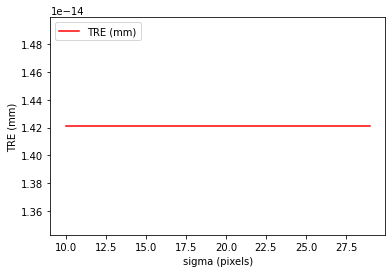

In [83]:
plt.plot(x_values, y_values, 'r', label='TRE (mm)')
plt.legend(loc='upper left')
plt.xlabel('sigma (pixels)')
plt.ylabel('TRE (mm)')
plt.show()